In [46]:


import pandas as pd
import numpy as np

## Preprocessing

In [47]:
# read the ratings.csv file
df = pd.read_csv('./data/ratings.csv')
#drop the timestamp column
df = df.drop('timestamp', axis=1)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [51]:
#print the number of rows in dataframe
print('Number of rows in dataframe before taking lower ratings: ', len(df))

# remove the rows having rating less than 2.0
df = df[df['rating'] >= 3.0]

print('Number of rows in dataframe after taking lower ratings: ', len(df))
#find the lowest and highest ratings
print('Lowest rating is: %d' %(df.rating.min()))
print('Highest rating is: %d' %(df.rating.max()))
# get the counts of total movies rated by each user
movie_count = df.groupby('userId')['movieId'].count()
movie_count
#find the minimum and maximum number of movies rated by a user
print('Minimum number of movies rated by a user: ', movie_count.min())
print('Maximum number of movies rated by a user: ', movie_count.max())




Number of rows in dataframe before taking lower ratings:  81763
Number of rows in dataframe after taking lower ratings:  81763
Lowest rating is: 3
Highest rating is: 5
Minimum number of movies rated by a user:  4
Maximum number of movies rated by a user:  2117


In [52]:
# for each user find the set of movies they rated and having a rating greater than 2
df = df.groupby('userId')['movieId'].apply(set)
df


userId
1      {1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ...
2      {115713, 122882, 48516, 91529, 80906, 131724, ...
3      {70946, 2851, 5764, 4518, 26409, 7991, 1275, 2...
4      {1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ...
5      {1, 515, 261, 265, 527, 531, 21, 150, 534, 153...
                             ...                        
606    {8195, 6148, 69644, 4109, 15, 17, 18, 2065, 20...
607    {1, 517, 2053, 2054, 1544, 3081, 11, 1036, 257...
608    {4105, 10, 6157, 16, 21, 31, 32, 2080, 34, 208...
609    {1, 137, 10, 650, 1161, 786, 150, 288, 161, 10...
610    {1, 122882, 122884, 6, 79879, 122886, 4105, 10...
Name: movieId, Length: 609, dtype: object

In [53]:
# sort the set based on the movide id
df = df.apply(sorted)


userId
1      [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...
2      [318, 333, 1704, 3578, 6874, 8798, 46970, 4851...
3      [849, 1275, 1371, 1587, 2288, 2851, 3024, 3703...
4      [21, 45, 52, 58, 106, 125, 162, 171, 176, 215,...
5      [1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232...
                             ...                        
606    [15, 17, 18, 28, 29, 32, 36, 46, 47, 50, 58, 6...
607    [1, 11, 25, 34, 36, 86, 110, 150, 153, 165, 18...
608    [10, 16, 21, 31, 32, 34, 39, 47, 50, 70, 104, ...
609    [1, 10, 110, 116, 137, 150, 161, 185, 208, 231...
610    [1, 6, 16, 32, 47, 50, 70, 95, 110, 111, 112, ...
Name: movieId, Length: 609, dtype: object

In [57]:
# consider only the users who have rated more than 10 movies
df = df[df.apply(lambda x: len(x)) > 10]
# print the minimum and maximum number of movies rated by a user
print('Minimum number of movies rated by a user: ', df.apply(lambda x: len(x)).min())
print('Maximum number of movies rated by a user: ', df.apply(lambda x: len(x)).max())


Minimum number of movies rated by a user:  11
Maximum number of movies rated by a user:  2117


In [58]:
# divide the data into training and test sets
# remove 20% of the data from each user and add it to the test set
# the remaining 80% of the data will be used for training
train = df.apply(lambda x: x[:int(len(x)*0.8)])
test = df.apply(lambda x: x[int(len(x)*0.8):])

## Q1

In [195]:
minsup = 0.1
minconf = 0.1
support_count = int(minsup * len(train))
l=[{}]
c1={}
for user in train:
    for movie in user:
        if (movie,) in c1:
            c1[(movie,)] += 1
        else:
            c1[(movie,)] = 1

print("Len of c1" , len(c1))



# remove the infrequent items from the candidate set
l1 = {k:v for k,v in c1.items() if v > support_count}
print("Len of l1" , len(l1))
l.append(l1)

Len of c1 6532
Len of l1 208


In [196]:
def check_subsets(cur, prev_size):
    for i in range(len(cur)):
        s = cur[:i] + cur[i+1:]
        #print(s)
        s= tuple(s)
        if s not in l[prev_size]:
            return False
    return True

def apriori_gen(l):
    c = []
    L = list(l.keys())
    
    try:
        L = [[i for i in l] for l in L]
        prev_size = len(list(l.keys())[0])
    except:
        L = [[l] for l in L]
        prev_size = 1
    
    
    
    for i in range(len(L)):
        for j in range(i+1, len(L)):
            if L[i][:-1] == L[j][:-1]:
                if(check_subsets(L[i] + [L[j][-1]], prev_size)):
                    c.append(sorted(L[i] + [L[j][-1]]))
    return c

In [197]:
# generate the candidate sets and frequent itemsets for k = 3,4,5
for i in range(2,10):
    c = apriori_gen(l[i-1])
    l.append({})
    for item in c:
        for user in train:
            if set(item).issubset(user):
                if tuple(item) in l[i]:
                    l[i][tuple(item)] += 1
                else:
                    l[i][tuple(item)] = 1
    l[i] = {k:v for k,v in l[i].items() if v > support_count}
    print("Len of l" + str(i) , len(l[i]))

Len of l2 1760
Len of l3 3171
Len of l4 2321
Len of l5 730
Len of l6 86
Len of l7 2
Len of l8 0
Len of l9 0


In [200]:
print(l[7])

{(260, 296, 356, 1196, 1210, 2028, 2571): 61, (260, 296, 356, 1196, 1210, 2571, 2959): 63}


In [232]:
# for each frequent itemset find the confidence
# if the confidence is greater than the minimum confidence then print the rule
# consider X->Y where X is of length one 

def insert_dic(movie, rightset):
    
    if movie in rules_dic:
        rules_dic[movie].append(rightset)
    
    else:
        rules_dic[movie] = [rightset]

RULES = []
rules_dic={}
temp = ""
for i in range(2,8):
    for k,v in l[i].items():
        for j in range(0, len(k)):
            x = k[j]
            y = [movies for movies in k if movies != x]
            confidence = v/l1[(x,)]

            if confidence > minconf:
                temp +=str(str(x) + '==>' + str(y) + ' confidence: ' + str(confidence) + ' support: ' + str(v/len(train)) + '\n')
                RULES.append((x,y,confidence, v/len(train)))
                insert_dic(x,y)
                



In [228]:
#write the rules to a file
with open('zoro_AssocRules.txt', 'w') as f:
    f.write(temp)


## Q2

In [229]:
# create 2 lists one sorted by confidence and the other sorted by support

rules_confidence = sorted(RULES, key=lambda x: x[2], reverse=True)
rules_support = sorted(RULES, key=lambda x: x[3], reverse=True)

# consider top 100 rules from each list
rules_confidence = rules_confidence[:100]
rules_support = rules_support[:100]

# print the rules and write them to a file
temp = ""
for rule in rules_confidence:
    temp += str(rule[0]) + '==>' + str(rule[1]) + ' confidence: ' + str(rule[2]) + ' support: ' + str(rule[3]) + '\n'
with open('zoro_top100RulesByConf.txt', 'w') as f:
    f.write(temp)

temp = ""
for rule in rules_support:
    temp += str(rule[0]) + '==>' + str(rule[1]) + ' confidence: ' + str(rule[2]) + ' support: ' + str(rule[3]) + '\n'

with open('zoro_top100RulesBySupport.txt', 'w') as f:
    f.write(temp)



# extract the rules common to both the lists
common_rules = []
for rule in rules_confidence:
    if rule in rules_support:
        common_rules.append(rule)

# sort the common rules based on the confidence
common_rules = sorted(common_rules, key=lambda x: x[2], reverse=True)


    

## Q3

In [239]:
import random
precision_list = []
recall_list = []
for k in range(1,10):
    k_precision = 0
    k_recall = 0
    for (user_movies, test_movies) in zip(train, test):
        #create a set of movies for this user
        rec_set = set()
        for movie in user_movies:
            if movie in rules_dic:
                rightsets = rules_dic[movie]
                # select k random rightsets from the list of rightsets
                k = min(k, len(rightsets))
                k_rightsets = random.sample(rightsets, k)
                for rightset in k_rightsets:
                    for m in rightset:
                        rec_set.add(m)
        
        # calculate the precision and recall for this user
        test_set = set(test_movies)

        hitset = rec_set.intersection(test_set)

        if(len(hitset)==0) :
            precision = 0
            recall = 0
        else:
            precision = len(hitset)/len(rec_set)
            recall = len(hitset)/len(test_set)
        
        k_precision += precision
        k_recall += recall

    precision_list.append(k_precision/len(train))
    recall_list.append(k_recall/len(train))
    


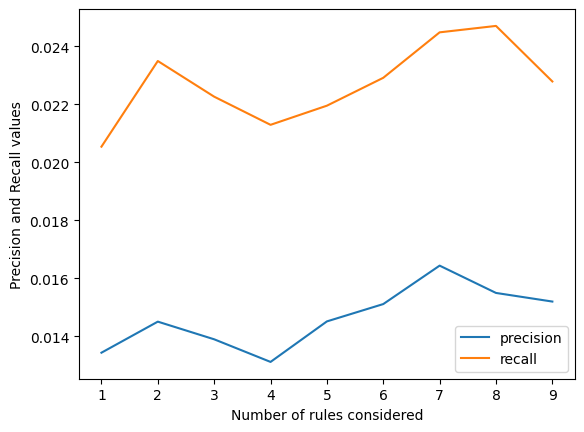

In [242]:
# plot the precision and recall for k = 1,2,3,4,5,6,7,8,9
import matplotlib.pyplot as plt
plt.plot([i for i in range(1,10)], precision_list, label='precision')
plt.plot([i for i in range(1,10)], recall_list, label='recall')
plt.xlabel('Number of rules considered')
plt.ylabel('Precision and Recall values')
plt.legend()
plt.show()


## Q4